### Model Development

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [222]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [225]:
df_merged = pd.read_csv("/home/nacheli/tinaProgramming/sppm/sppm/sppm/merged_data.csv")

### Filling NAN values in the merged dataset and cleaning duplicate values

### Show Top 5 Records

In [229]:
# Check for duplicate column names and remove them
if df_merged.columns.duplicated().any():
    print("Warning: There are duplicate column names in the dataframe.")
    # Removing duplicate columns by keeping the first occurrence
    df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]

# Remove duplicate rows
df_cleaned = df_merged.drop_duplicates()

# Check for NaN values
nan_summary = df_cleaned.isna().sum()

# Option 1: Fill NaN values with 0
df_cleaned.loc[:, :] = df_cleaned.fillna(0)

# Option 2: Fill NaN values with the mean of each numeric column
numeric_cols = df_cleaned.select_dtypes(include=['number']).columns

# Calculate means for numeric columns
means = df_cleaned[numeric_cols].mean()

# Fill NaN values in the numeric columns with their respective means
for col in numeric_cols:
    df_cleaned.loc[:, col] = df_cleaned[col].fillna(means[col])

# Drop rows with NaN values (if necessary after filling NaNs)
df_cleaned = df_cleaned.dropna()

# Encoding the 'gender' feature using one-hot encoding
df_encoded = pd.get_dummies(df_cleaned, columns=['gender'], drop_first=True)

# View the cleaned dataframe
print(df_encoded.head())


  race_ethnicity parental_level_of_education         lunch  \
0        group B           bachelor's degree      standard   
1        group C                some college      standard   
2        group B             master's degree      standard   
3        group A          associate's degree  free/reduced   
4        group C                some college      standard   

  test_preparation_course  math_score  reading_score  writing_score  \
0                    none          72             72             74   
1               completed          69             90             88   
2                    none          90             95             93   
3                    none          47             57             44   
4                    none          76             78             75   

  parental_level_of_education.1  math_score.1  reading_score.1  \
0              some high school          63.0             78.0   
1                  some college          98.0             86.0   
2 

#### Preparing X and Y variables

In [232]:
X = df_encoded.drop(columns=['math_score'],axis=1)

In [234]:
X.head

<bound method NDFrame.head of     race_ethnicity parental_level_of_education         lunch  \
0          group B           bachelor's degree      standard   
1          group C                some college      standard   
2          group B             master's degree      standard   
3          group A          associate's degree  free/reduced   
4          group C                some college      standard   
..             ...                         ...           ...   
995        group E             master's degree      standard   
996        group C                 high school  free/reduced   
997        group C                 high school  free/reduced   
998        group D                some college      standard   
999        group D                some college  free/reduced   

    test_preparation_course  reading_score  writing_score  \
0                      none             72             74   
1                 completed             90             88   
2                 

In [236]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(df['race_ethnicity'].unique())

print("Categories in'parental_level_of_education' variable:",end=" " )
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test_preparation_course' variable:     ",end=" " )
print(df['test_preparation_course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental_level_of_education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test_preparation_course' variable:      ['none' 'completed']


In [238]:
y = df['math_score']

In [240]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

# Create Column Transformer with 3 types of transformers


In [243]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Convert all object-type columns to strings (to ensure categorical columns are uniform in type)
X[cat_features] = X[cat_features].astype(str)

# Define the column transformers for numerical and categorical features
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(handle_unknown='ignore')  # handle_unknown='ignore' prevents issues with unseen categories during transformation

# Combine both transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features),
    ]
)

# Fit and transform the dataset
X_preprocessed = preprocessor.fit_transform(X)

# If you want to convert the transformed data back into a dataframe
# Extract one-hot encoded feature names from the OneHotEncoder
encoded_features = preprocessor.named_transformers_['OneHotEncoder'].get_feature_names_out(cat_features)

# Combine numeric and encoded categorical columns back into a dataframe
X_preprocessed_df = pd.DataFrame(
    X_preprocessed, 
    columns=encoded_features.tolist() + num_features.tolist()
)

print(X_preprocessed_df.head())


   race_ethnicity_group A  race_ethnicity_group B  race_ethnicity_group C  \
0                     0.0                     1.0                     0.0   
1                     0.0                     0.0                     1.0   
2                     0.0                     1.0                     0.0   
3                     1.0                     0.0                     0.0   
4                     0.0                     0.0                     1.0   

   race_ethnicity_group D  race_ethnicity_group E  \
0                     0.0                     0.0   
1                     0.0                     0.0   
2                     0.0                     0.0   
3                     0.0                     0.0   
4                     0.0                     0.0   

   parental_level_of_education_associate's degree  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3     

In [245]:
X_preprocessed.shape

(1000, 27)

# separate dataset into train and test


In [248]:
from sklearn.model_selection import train_test_split
X_preprocessed_train, X_preprocessed_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_preprocessed_train.shape, X_preprocessed_test.shape

((800, 12), (200, 12))

#### Create an Evaluate Function to give all metrics after model Training

In [251]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [253]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Preprocessing
num_features = X_train.select_dtypes(exclude="object").columns
cat_features = X_train.select_dtypes(include="object").columns

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", oh_transformer, cat_features),
    ]
)

X_preprocessed_train = preprocessor.fit_transform(X_train)
X_preprocessed_test = preprocessor.transform(X_test)

# Model dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(enable_categorical=False),  # Set enable_categorical if needed
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list = []

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    try:
        # Fit the model
        model.fit(X_preprocessed_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_preprocessed_train)
        y_test_pred = model.predict(X_preprocessed_test)

        # Evaluate model
        model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
        model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

        # Print results
        print(f"{model_name}")
        print('Model performance for Training set')
        print(f"- Root Mean Squared Error: {model_train_rmse:.4f}")
        print(f"- Mean Absolute Error: {model_train_mae:.4f}")
        print(f"- R2 Score: {model_train_r2:.4f}")
        
        print('----------------------------------')

        print('Model performance for Test set')
        print(f"- Root Mean Squared Error: {model_test_rmse:.4f}")
        print(f"- Mean Absolute Error: {model_test_mae:.4f}")
        print(f"- R2 Score: {model_test_r2:.4f}")
        
        model_list.append(model_name)
        r2_list.append(model_test_r2)
        
        print('=' * 35)
        print('\n')

    except Exception as e:
        print(f"Error encountered while training {model_name}: {e}")
        print('=' * 35)


Training Linear Regression...
Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.2996
- Mean Absolute Error: 4.2286
- R2 Score: 0.8754
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3916
- Mean Absolute Error: 4.2154
- R2 Score: 0.8805


Training Lasso...
Lasso
Model performance for Training set
- Root Mean Squared Error: 6.3076
- Mean Absolute Error: 4.9968
- R2 Score: 0.8235
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.1304
- Mean Absolute Error: 4.8449
- R2 Score: 0.8456


Training Ridge...
Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3033
- Mean Absolute Error: 4.2407
- R2 Score: 0.8752
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3888
- Mean Absolute Error: 4.2117
- R2 Score: 0.8807


Training K-Neighbors Regressor...
K-Neighbors Regressor
Model performance for Training set
- Root

In [254]:
# Initialize models
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "CatBoosting": CatBoostRegressor(verbose=False),
    "Random Forest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBRegressor": XGBRegressor(),
    "K-Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
}

# Store predictions
predictions = {}

for model_name, model in models.items():
    model.fit(X_preprocessed_train, y_train)
    y_pred = model.predict(X_preprocessed_test)
    predictions[model_name] = y_pred  # Store predictions

# You can now access predictions like this:
y_pred_ridge = predictions["Ridge"]
y_pred_lasso = predictions["Lasso"]
y_pred_catboost = predictions["CatBoosting"]
y_pred_rf = predictions["Random Forest"]
y_pred_ada = predictions["AdaBoost"]
y_pred_xgb = predictions["XGBRegressor"]
y_pred_knn = predictions["K-Neighbors"]
y_pred_dt = predictions["Decision Tree"]


### Results

In [256]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880663
0,Linear Regression,0.880540
7,CatBoosting Regressor,0.859741
5,Random Forest Regressor,0.852357
8,AdaBoost Regressor,0.847360
1,Lasso,0.845556
6,XGBRegressor,0.830838
3,K-Neighbors Regressor,0.803920
4,Decision Tree,0.764690


## Linear Regression

In [259]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_preprocessed_train, y_train)
y_pred = lin_model.predict(X_preprocessed_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.05


## Plot y_pred and y_test

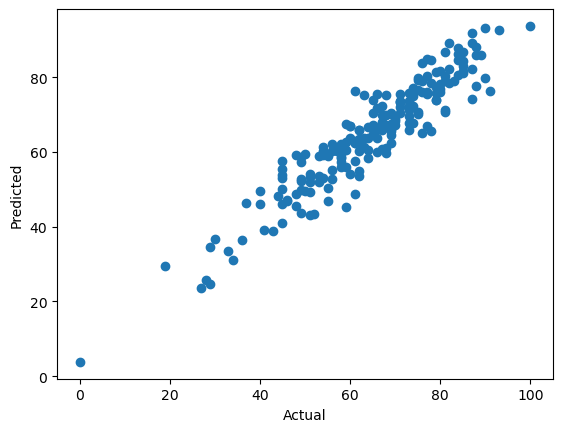

In [261]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

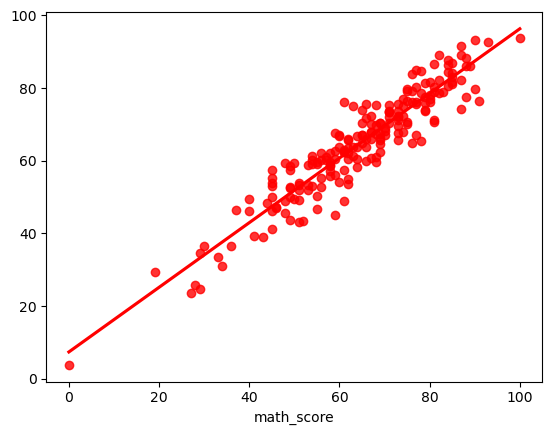

In [264]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

### Difference between Actual and Predicted Values

In [267]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.439402,14.560598
737,53,58.862486,-5.862486
740,80,76.921063,3.078937
660,74,76.996774,-2.996774
411,84,87.753828,-3.753828
...,...,...,...
408,52,43.436510,8.563490
332,62,62.201963,-0.201963
208,74,67.888376,6.111624
613,65,67.078566,-2.078566


### Accuracy results of other models

In [269]:
from sklearn.metrics import r2_score

# Define models, excluding Linear Regression
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

# Loop through models and evaluate their accuracy
for model_name, model in models.items():
    try:
        # Fit the model
        model.fit(X_preprocessed_train, y_train)
        
        # Make predictions on the test data
        y_pred = model.predict(X_preprocessed_test)
        
        # Calculate R2 score and convert to percentage
        score = r2_score(y_test, y_pred) * 100
        
        # Print the accuracy
        print(f"Accuracy of the {model_name} model is: {score:.2f}%")
    
    except Exception as e:
        # Handle any errors that occur
        print(f"Error encountered while training {model_name}: {e}")


Accuracy of the Lasso model is: 84.56%
Accuracy of the Ridge model is: 88.07%
Accuracy of the K-Neighbors Regressor model is: 80.39%
Accuracy of the Decision Tree model is: 74.70%
Accuracy of the Random Forest Regressor model is: 84.88%
Accuracy of the XGBRegressor model is: 83.08%
Accuracy of the CatBoosting Regressor model is: 85.97%
Accuracy of the AdaBoost Regressor model is: 84.82%


### PLotting predictions

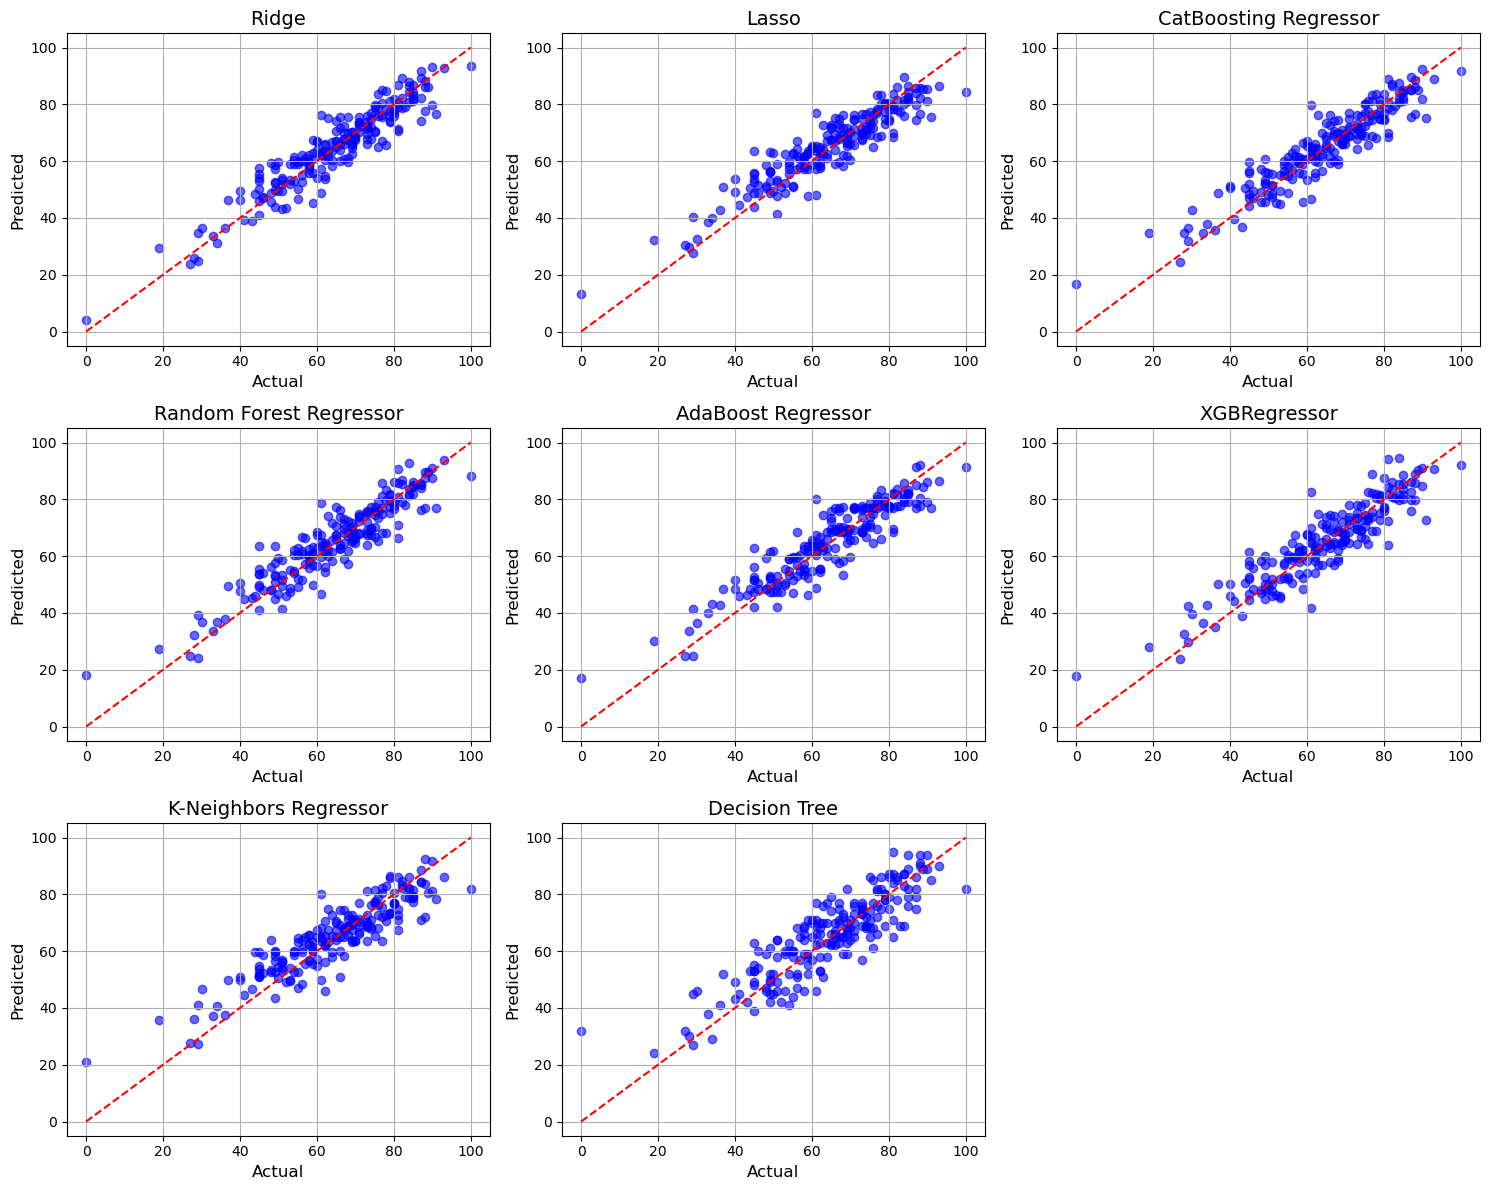

In [271]:
import matplotlib.pyplot as plt

# List of models except Linear Regression
models = [
    "Ridge",
    "Lasso",
    "CatBoosting Regressor",
    "Random Forest Regressor",
    "AdaBoost Regressor",
    "XGBRegressor",
    "K-Neighbors Regressor",
    "Decision Tree"
]

# Assuming you have y_test and a dictionary of predictions for each model
predictions = {
    "Ridge": y_pred_ridge,
    "Lasso": y_pred_lasso,
    "CatBoosting Regressor": y_pred_catboost,
    "Random Forest Regressor": y_pred_rf,
    "AdaBoost Regressor": y_pred_ada,
    "XGBRegressor": y_pred_xgb,
    "K-Neighbors Regressor": y_pred_knn,
    "Decision Tree": y_pred_dt,
}

# Plotting Actual vs Predicted for each model
plt.figure(figsize=(15, 12))

for i, model in enumerate(models):
    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
    plt.scatter(y_test, predictions[model], color='blue', alpha=0.6)
    plt.xlabel('Actual', fontsize=12)
    plt.ylabel('Predicted', fontsize=12)
    plt.title(f'{model}', fontsize=14)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line for reference
    plt.grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show all plots


### Model Evaluation

### Ridge model 

In [274]:
# Assuming you have already trained the model like this:
ridge_model = Ridge(fit_intercept=True)
ridge_model.fit(X_preprocessed_train, y_train)  # Fit the model with training data

# Evaluate on the test set
y_pred = ridge_model.predict(X_preprocessed_test)  # Use the instance of the model here

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error: 4.2117
Root Mean Squared Error: 5.3888
R² Score: 0.8807


###  Fine-Tuning the Model (Hyperparameter Tuning)

In [276]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'alpha': [0.1, 1, 10, 100]}  # Example parameter for Ridge

# Initialize GridSearchCV
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')

# Fit the model
grid_search.fit(X_preprocessed_train, y_train)

# Get the best parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'alpha': 1}


### Final Model Training

In [281]:

ridge_model = Ridge(alpha=1)
ridge_model.fit(X_preprocessed_train, y_train)  # Use your training data


Ridge(alpha=1)

### Evaluating the Model:
- After training, evaluate its performance using appropriate metrics on your validation or test datasets to see how well it generalizes.



In [295]:

ridge_model = Ridge(alpha=1)  # Use the best alpha value
ridge_model.fit(X_preprocessed_train, y_train)  # Train the model

# Evaluate on the test set
y_pred = ridge_model.predict(X_preprocessed_test)  # Make predictions

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score

# Print the evaluation metrics
print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 4.2117
Root Mean Squared Error (RMSE): 5.3888
R² Score: 0.8807


### Making Predictions

In [300]:
# Preprocess the dataset the same way as your training data
X_preprocessed = preprocessor.transform(X)

# Make predictions using the trained model
predictions = ridge_model.predict(X_preprocessed)  # Use the model to predict

# Optionally, if you want to see the actual values alongside predictions
pred_df = pd.DataFrame({
    'Actual Value': y,  # Your actual target variable
    'Predicted Value': predictions,
    'Difference': y - predictions
})

# Output the predictions and differences
print(pred_df)


     Actual Value  Predicted Value  Difference
0              72        70.968102    1.031898
1              69        71.305444   -2.305444
2              90        86.111865    3.888135
3              47        49.388305   -2.388305
4              76        77.238482   -1.238482
..            ...              ...         ...
995            88        88.301994   -0.301994
996            62        58.513936    3.486064
997            59        53.371344    5.628656
998            68        67.301212    0.698788
999            77        75.365725    1.634275

[1000 rows x 3 columns]
